In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

# 1. 이미지 준비

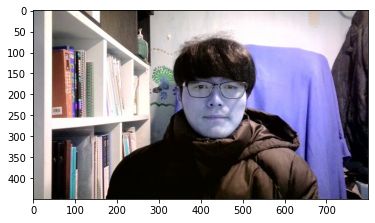

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/myimage.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

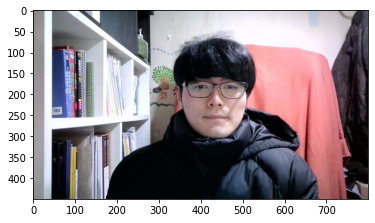

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# 2. 얼굴 검출 (face detection)

In [4]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

In [5]:
print(dlib_rects)

rectangles[[(356, 150) (511, 305)]]


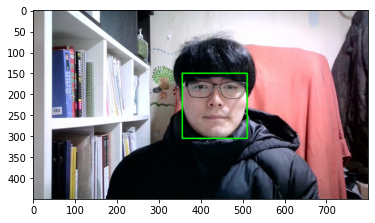

In [6]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 3. 얼굴 랜드마크 (face landmark)

In [7]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [8]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


### Object keypoint estimation 알고리즘 중 top-down 방식을 사용

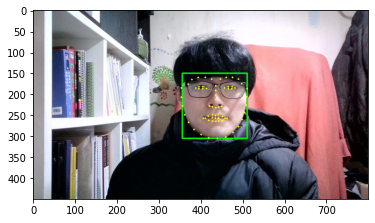

In [9]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 4. 얼굴 스티커 사용하기

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33])
    x = landmark[33][0]
    y = landmark[33][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(436, 232)
(x,y) : (436,154)
(w,h) : (156,156)


[두 직선의 교점 구하기](https://gaussian37.github.io/math-algorithm-intersection_point/)

In [11]:
x1 = landmark[2][0]; y1 = landmark[2][1]
x2 = landmark[30][0]; y2 = landmark[30][1]
x3 = landmark[36][0]; y3 = landmark[36][1]
x4 = landmark[48][0]; y4 = landmark[48][1]

x5 = landmark[14][0]; y5 = landmark[14][1]
x6 = landmark[30][0]; y6 = landmark[30][1]
x7 = landmark[45][0]; y7 = landmark[45][1]
x8 = landmark[54][0]; y8 = landmark[54][1]

    
print ('(x1,y1) : (%d,%d)'%(x1,y1))
print ('(x2,y2) : (%d,%d)'%(x2,y2))
print ('(x3,y3) : (%d,%d)'%(x3,y3))
print ('(x4,y4) : (%d,%d)'%(x4,y4))
print('-'*30)
print ('(x5,y5) : (%d,%d)'%(x5,y5))
print ('(x6,y6) : (%d,%d)'%(x6,y6))
print ('(x7,y7) : (%d,%d)'%(x7,y7))
print ('(x8,y8) : (%d,%d)'%(x8,y8))

(x1,y1) : (357,228)
(x2,y2) : (436,213)
(x3,y3) : (388,185)
(x4,y4) : (406,257)
------------------------------
(x5,y5) : (509,226)
(x6,y6) : (436,213)
(x7,y7) : (482,185)
(x8,y8) : (463,257)


In [12]:
Px1 = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4))//((x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4))
Py1 = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4))//((x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4))
cv2.circle(img_show, (Px1,Py1), 5, (0, 0, 255), -1)
print('(Px1, Py1) : (%d, %d)'%(Px1,Py1))

(Px1, Py1) : (396, 220)


In [13]:
Px2 = ((x5*y6 - y5*x6)*(x7 - x8) - (x5 - x6)*(x7*y8 - y7*x8))//((x5 - x6)*(y7 - y8) - (y5 - y6)*(x7 - x8))
Py2 = ((x5*y6 - y5*x6)*(y7 - y8) - (y5 - y6)*(x7*y8 - y7*x8))//((x5 - x6)*(y7 - y8) - (y5 - y6)*(x7 - x8))
cv2.circle(img_show, (Px2,Py2), 5, (0, 0, 255), -1)
print('(Px2, Py2) : (%d, %d)'%(Px2,Py2))

(Px2, Py2) : (472, 219)


(x,y) : (436,154)
(w_t,h_t) : (76,76)


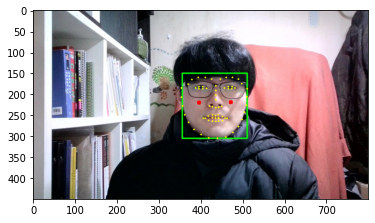

In [14]:
w_t = Px2 - Px1
h_t = Px2 - Px1
        
#w_t = dlib_rect.width()
#h_t = dlib_rect.width()
print ('(x,y) : (%d,%d)'%(x,y))
print ('(w_t,h_t) : (%d,%d)'%(w_t,h_t))

img_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show)
plt.show()

In [15]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w_t,h_t))
print (img_sticker.shape)

(156, 156, 3)


In [16]:
refined_x = x - w // 2
refined_y = y 
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (358,154)


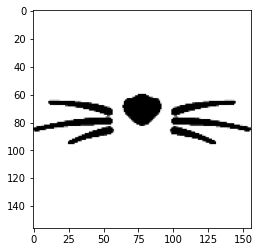

In [17]:
plt.imshow(img_sticker)

In [18]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (358,154)


In [19]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

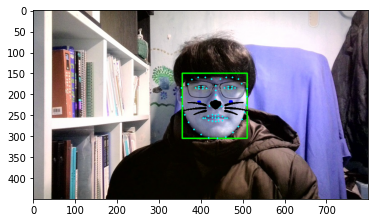

In [20]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

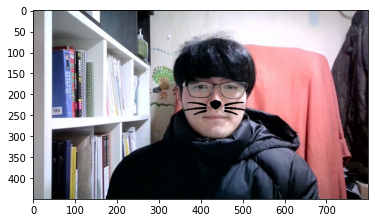

In [21]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 5. 정면이 아닌 옆면으로 찍었을 때